# Black-Litterman Code Explained

Based on [*Sector Weighting: A Detailed Implementation of Black-Litterman*](http://kpei.github.io/bl-sector-ssif/bl.html) by Kevin Pei, Senior Portfolio Analyst for Sprott Student Investment Fund. The R code provided by this source was converted to Python code, then modified to improve flexibility and remove instances of hard coding to allow for use in a trading strategy.

# Background

The Black-Litterman model for portfolio allocation was created by Fischer Black and Robert Litterman in 1990 at Goldman Sachs as a means of improving upon the mean variance optimization (MVO) method of portfolio allocation. Specifically, it overcomes the two main issues that arise from using the MVO method:

1. Creation of unintuitive, poorly diversified/highly concentrated portfolios.
2. High sensitivity of portfolios to return forecast adjustments.

The BL model enables investors to outline what they consider to be a consensus portfolio (Typically a portfolio with weights proportional to the market capitalization of the assets in question is used) which is then used to produce a set of implied returns. These implied returns, when input into the MVO algorithm, ultimately force the efficient frontier produced to be anchored to the consensus portfolio at the point of maximum Sharpe ratio. This makes the different portfolios along the efficient frontier more intuitive and diversified since the efficient frontier smoothly moves away from the consensus portfolio as it moves away from the maximum Sharpe ratio.

The second problem that BL model resolves centers around how portfolio weights can drastically change when an investor believes an asset will stray from its historical returns and adjusts its return accordingly. BL model resolves this by taking the modifications investors make to the return of each individual asset in the portfolio and adjusting the return forecasts of all assets in the portfolio based on these modifications through generalized least squares estimation that considers all the correlations amongst the assets of the portfolio. 

The main assumptions of the Black-Litterman are as follows: 

- Asset returns and the expected values of asset returns are normally distributed
- The covariance of returns can be calculated
- Expected returns do not deviate far from equilibrium returns
- Investor views are uncorrelated

# Process Overview

For this project, the BL model was utilized to allocate investments into stocks with the output from a stock forecasting algorithm used as the input investor views into the model. There are four main steps that the BL function goes through in order to generate proper portfolio weights.

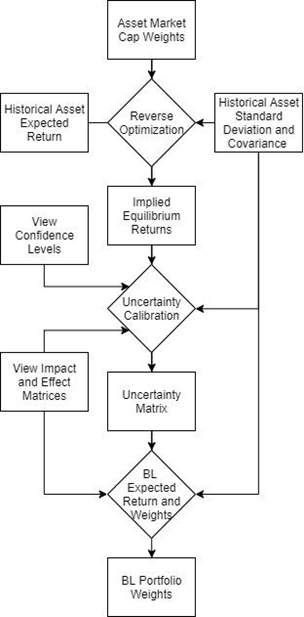

1. Implied equilibrium returns (π) are generated through reverse optimization using the historical returns of the assets selected by the stock forecasting algorithm and portfolio weights proportional to the market capitalization of the selected stocks.
2. The view impact (Q) and effect (P) matrices are constructed using the output return levels from the stock forecasting algorithm.
3. The uncertainty matrix (Ω) detailing the variance of each view is determined by selecting the value of Ω[k,k] that minimizes the squared difference between the confidence adjusted portfolio weights and the portfolio weights generated by view k alone.
4. The Black Litterman formula for expected return is utilized to determine the expected return with the π, Q, P, and Ω determined in previous steps, along with the covariance of the historical returns as input.
5. Black Litterman expected return is utilized with the historical return covariance to determine the Black Litterman weights through reverse reverse optimization.

This process, along with the code used to execute it, will be discussed and shown in the following sections.

# Initial Setup
## *Load Necessary Libraries*

NumPy, the inv() function from the linear algebra library of NumPy, Pandas, and the timedelta function from datetime are used in the following code and are imported here.

In [1]:
import numpy as np
from numpy.linalg import inv as solver
import pandas as pd
from datetime import timedelta

## *Load Necessary Data*

The Black Litterman model will need 
- The historical log returns from 30 days prior to the trading date of the stocks selected by our stock forecasting algorithm
- The stock market capitalization of the stocks selected by our stock forecasting algorithm
- The LIBOR rate on the trade date

The importing of this data is shown here, but the stand alone Black-Litterman function takes these dataframes as input arguments.

In [2]:
# Import all log return data
r = pd.read_csv('log_ret_data_final.csv',index_col='date', parse_dates=True)
# Import market cap data
mkt_cap = pd.read_csv('mark_cap_data_final.csv',index_col='date', parse_dates=True)
# Read in and format 3 month LIBOR rate data
risk_free = pd.read_csv('libor_rates_final.csv',index_col='date', parse_dates=True)

## *Assumed Stock Forecasting Algorithm Output*

This project involved a stock forecasting algorithm which would predict how well the stocks on the NASDAQ 100 would do over the coming week and give them a predicted level of return labelled from 0, meaning lowest performing, to 7, meaning highest performing. This algorithm would then output the CUSIPs of the stocks predicted to perform the best along with their predicted level of return.

As such, the following shows sample output from the stock forecasting algorithm and how this output was reformatted for the purposes of the Black-Litterman model. The output is in the form of a tuple, with the first element containing the trading date and the second element containing a dict, with keys equal to selected stock CUSIP identifiers and values equal to the level of return that stock is expected to return.

This specific part is more important for the stand alone Black-Litterman function created later than for this specific file.

In [3]:
# Sample stock forecasting algorithm output
smp_out = (pd.to_datetime('1995-07-03'),{'91704710':7, '15678210':0, '15102010':5, '53279110':5})
# Separate the stock forecasting method output dict into its individual components
smp_out_date = smp_out[0]
smp_out_names = list(smp_out[1].keys())
smp_out_lvls = list(smp_out[1].values())

## *Return Data and Statistics for Desired Stocks*

Initially, the complete dataset of log returns for all NASDAQ 100 stocks was imported since the stock forecasting algorithm output wasn't known. Since the stock forecasting algorithm output was since defined, the log return data is filtered to only include the historical log returns of the stocks selected by our stock forecasting algorithm from the 180 days before the stock forecasting algorithm's output to the trade date in the stock forecasting algoritm's output.

In [4]:
# Create filtered log return dataframe
test_r = r.filter(items=smp_out_names).loc[(smp_out_date-timedelta(days=180)):smp_out_date]

Below, the standard deviations of the stock returns in the filtered log return dataframe, along with its correlation and covariance matrices are found.

In [5]:
# Standard Deviation of Stock Returns
sigma = np.matrix(test_r.apply(np.std).values)
# Correlation Matrix
rho = test_r.corr()
# Covariance Matrix
cov_mat = np.matrix(rho * np.matmul(sigma.transpose(), sigma))

# Reverse Optimization to Find the Implied Optimal Returns

In order to determine the implied optimal returns for Black-Litterman, it is assumed that the consensus portfolio of weights proportional to the market capitalization of the stocks is the optimal portfolio. To find the implied optimal returns, the risk aversion coefficient must be found first.

## *Determine the Risk Aversion Coefficient $(\lambda)$*

The risk aversion coefficient is determined using the expected return and variance of the consensus portfolio and the risk free rate on the trading date.

$$
\lambda = \frac{E[R]-r_{free}}{\sigma^2}
$$

The code to find this is as follows

In [6]:
# Market Cap Data for Chosen Stocks on Given Day
test_mc = mkt_cap.filter(items=smp_out_names).loc[smp_out_date]

# Calculate Weights from Market Caps
test_wts = test_mc.div(test_mc.sum(axis=0), axis=0)
# Get Weekly Expected Return
r_total = np.matrix(np.matmul(np.matrix(test_r), test_wts.transpose())).transpose()
exp_wk_r = np.mean(r_total)*5

# 3 Month LIBOR Rate Converted to a Daily Rate by Dividing by 90
rf = float(risk_free.loc[smp_out_date])/(100*90.0)
# Variance of Total Return
var = np.var(r_total)
# Determine Lambda
lam = (exp_wk_r-rf)/var

## *Determine Implied Optimal Returns $(\pi)$*

Implied optimal returns are calculated by scaling the product of the return covariance and consensus portfolio weights by the risk aversion coefficient.

$$
\pi = \lambda \Sigma w_{consensus}
$$

In [7]:
w_mkt = np.matrix(test_wts)
pi = lam * np.matmul(np.matrix(cov_mat), np.matrix(test_wts).transpose())

# Taking Stock Forecasts and/or Views into Account

For this project, the [0,7] level output from the stock forecasting algorithm was used as the "investor view". It is assumed that stocks with higher levels than other stocks will outperform those stocks in a way proportional to the difference in the stocks levels. Furthermore, any two stocks that share the same level will perform in an equivalent manner.

For instance, the sample stock forecasting output here is:
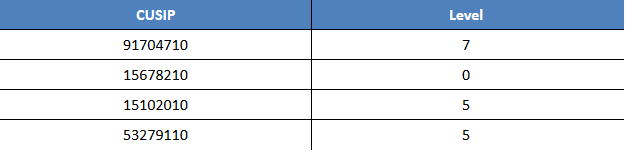

Describing the outperformance of stock 91704710 in comparison to the other stocks would be done using proportional weights to the difference in the stocks levels as follows:
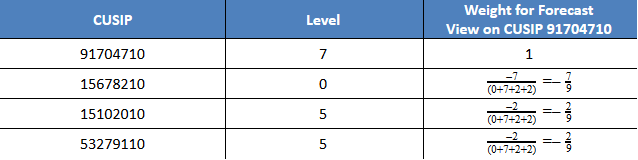

On the other hand, describing the outperformance of stock 53279110 in comparison to the other stocks would be done using proportional weights to the difference in the stocks levels as well.
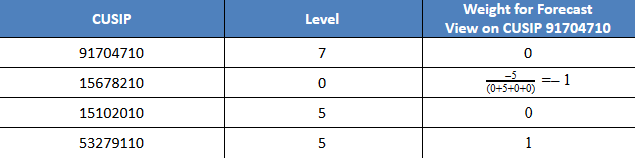

## *Impact Vector (Q)*

The impact vector Q holds the consequences on the return that each investor view, other than those of the lowest level, has. Q has a length of the number of views for returns above the minumum level, K. For instance, going back to the example stock forecast output:
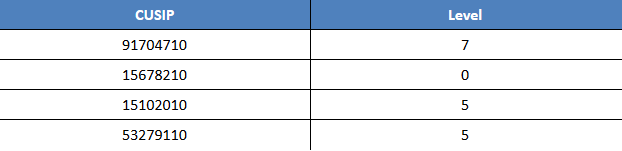

The impact of these views is the return that each level implies the stock will return. Through analyzing the results of the stock forecasting algorithm, it was determined that the expected returns for each level are as follows:
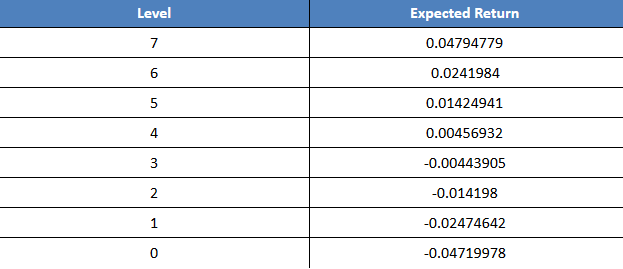

From this information, the impact matrix for the sample stock forecast output is

$$
Q=[0.04794779, 0.01424941, 0.01424941]
$$

where the expected returns, and hence the impacts, of the investor views on CUSIPs 91704710, 15102010, and 53279110, or the CUSIPs that don’t have the minimum level of the sample output, are stored.

The creation of this kind of impact vector was automated as follows:

In [8]:
# impact_maker creates the impact matrix from the level output.
# lvl_ret is a dictionary of levels and their corresponding expected return
def impact_maker(vec, lvl_ret={0:-0.04719978, 1:-0.02474642, 2:-0.014198, 3:-0.00443905, 4:0.00456932,
                               5:0.01424941, 6:0.0241984, 7:0.04794779}):
    # Find the minimum element of the input vector
    m_vec = min(vec)
    # For each element in the input vector that is not the minimum, make a vector of the expected returns
    # corresponding to the element
    q = [lvl_ret[i] for i in vec if i!=m_vec]
    # Return the impact vector
    return(q)

Q = impact_maker(smp_out_lvls)
Q

[0.04794779, 0.01424941, 0.01424941]

## *Effect Matrix P*

The effect matrix P is a K-by-N matrix where K is still the number of views for returns above the minimum level and N is the number of stocks in the stock forecast selection. This matrix indicates which stocks are affected by each belief in the manner described at the beginning of this section, specifically indicating which stocks are expected to perform worse than the stock of the view in question in a way proportional to the difference in the stocks levels. The creation of this kind of effect matrix was automated as follows:

In [9]:
# effect_maker creates the effect matrix from the level output
def effect_maker(vec):
    # Determine the minimum element of vec
    m_vec = min(vec)
    # Generate empty matrix to hold the views. Rows are the number of entries not equal to the minimum level, 
    # columns are the total number of entries in vec.
    p = np.zeros((len(vec)-vec.count(m_vec),len(vec)))
    
    # Create dummy variables ind and j to keep track of the index of vec we are looking at and the row of the
    # effect matrix we are interested in respectively
    ind=0
    j=0
    # Loop through all the elements in vec
    for elem in vec:
        # If the current element is equal to the minimum, do nothing but add 1 to ind
        if elem == m_vec:
            ind=ind+1
            continue
        # If the current element isn't equal to the minimum
        else:
            # Create a list of the differences between the current element and any element in the vector that
            # is less than it. Otherwise, let the input entry be 0. 
            cur_row = [i-elem if i<elem else 0.0 for i in vec]
            # Find the denominator of the weights for current the effect matrix row by summing the absolute
            # values of all the cur_row elements
            denom = sum(np.absolute(cur_row))
            # Divide all the cur_row elements by denom
            cur_row = [i/denom for i in cur_row]
            # Set the element in the cur_row corresponding to the current element being looked at to 1
            cur_row[ind] = 1
            # Input the row into the effect matrix
            p[j]=cur_row 
            # Increment the dummy variables
            j=j+1
            ind=ind+1
            
    # Retern the generated effect matrix
    return(np.matrix(p))

P = effect_maker(smp_out_lvls)
P

matrix([[ 1.        , -0.63636364, -0.18181818, -0.18181818],
        [ 0.        , -1.        ,  1.        ,  0.        ],
        [ 0.        , -1.        ,  0.        ,  1.        ]])

## *Uncertainty Matrix $\Omega$ and Calibrating Confidence Levels (of the Views)*

The uncertainty matrix  is a K-by-K diagonal-positive matrix holding the variance for each view, where K is still the number of views for returns above the minimum return level.

The confidence level of a view represents its reliability on a scale of 0% to 100%. Assuming that an investor is 100% certain in their view, the expected return of their portfolio is then:

$$
E\left[R_{100\%}\right] = \pi + \tau \Sigma P^T \left(P\tau \Sigma P^T\right)^{-1}\left(Q-P\pi\right)
$$

and then the Black-Litterman weights of the portfolio would be found using

$$
w_{100\%}=\left(\lambda \Sigma \right)^{-1} E\left[R_{100\%}\right]
$$

From analyzing the accuracy of the stock forecast method, a confidence level of 35% was decided upon for use on each view. Since this confidence is not 100%, the Black-Litterman weighted portfolio will not deviate from the consensus portfolio with the stock forecast views by 100%. Instead, let

$$
\Delta_{w} = \left(w_{100\%} - w_{consensus}\right)*0.35
$$

be an N-by-1 vector denoting how far the Black-Litterman model will deviate from the consensus portfolio weights based on the stock forecast algorithm views.

To determine $\Omega$. the following procedure was followed for each individual view k of the totak K views in the impact (Q) and effect (P) matrices:

1. The confidence level for each view is defined. A single 35% confidence level was used for each view since each view came from the same stock forecasting algorithm, hence having the same accuracy. It is possible to use different confidence levels for each individual view if necessary/better suited for the views used.

2. The Black-Litterman expected return and Black-Litterman weights for a portfolio based on 100% confidence in the stock forecast view k are determined using the formulae
$$
E_k\left[R_{100\%}\right] = \pi + \tau \Sigma P_k^T \left(P_k\tau \Sigma P_k^T\right)^{-1}\left(Q_k-P_k\pi\right) \\
w_{k,100\%} = \left(\lambda \Sigma\right)^{-1}E\left[R_{100\%}\right]
$$
where $Q_k$ and $P_k$ are the $k^{th}$ rows of the impact and effect matrices respectively.
3. $\Delta_{w} = \left(w_{100\%} - w_{consensus}\right)*0.35$ is found and used to calculate the confidence adjusted portfolio weights $w_{conf. adj.}=w_{consensus}+\Delta_w$

4. The uncertainty matrix entry $\Omega_{k,k}$ for view k is established by minimizing the squared difference between the confidence adjusted weighting $w_{conf. adj.}$ and the Black-Litterman weighting
$$
w_k=\left(\lambda\Sigma\right)^{-1}
\left[\left(\tau\Sigma\right)^{-1}+P_k^T\Omega_{k,k}^{-1}P_k\right]^{-1}
\left[\left(\tau\Sigma\right)^{-1}\pi+P_k^T\Omega_{k,k}^{-1}Q_k\right]
$$
The code for this project manages to do this by looping over values of $\Omega_{k,k}$ from 0.00001 to 0.001, computing the Black-Litterman weighting $w_k$ for each possible $\Omega_{k,k}$, taking the squared difference between each $w_k$ and the confidence adjusted weighting $w_{conf. adj.}$, and finally setting $\Omega_{k,k}$ equal to the value of $\Omega_{k,k}$ that produced the smallest squared difference. 

The code used to calibrate the uncertainty matrix $\Omega$ using confidence levels is as follows:

In [10]:
# Define objective function to be minimized for step 5
# ie. squared difference between the confidence weighting and Black-Litterman output weighting)
def omega_solve(omega, w_conf_k, lam, sigma, tau, p, pi, q):
    w_single =np.matmul(solver(lam*sigma),
                        np.matmul(solver(solver(tau*sigma) + np.matmul(p.transpose(), (1/omega)*p)), 
                        (np.matmul(solver(tau*sigma), pi) + p.transpose() * (1/omega)*q)))
    return(np.matrix.sum(np.square(np.subtract(w_conf_k, w_single))))


# STEP 1: Set confidence levels
cf_lvls = np.repeat(.35, len(P))

K = P.shape[0]
tau=0.005
omega = np.zeros((K,K))

# Loop through each view
for i in range(0,K):
    # STEP 2
    bl_er_100 = pi + np.matmul(np.matmul(np.matmul(tau*cov_mat, P[i,:].transpose()), 
                                         solver(np.matmul(P[i,:] * tau, cov_mat*P[i,:].transpose()))),
                               Q[i]-P[i,:]*pi)
    w_bl_100 = np.matmul(solver(lam*cov_mat), bl_er_100)
    
    # STEP 3
    tilt = (w_bl_100 - w_mkt.transpose())*cf_lvls[i]
    w_cf_k = w_mkt.transpose() + tilt
    
    # STEP 4
    m = np.arange(0.00001,0.001,0.00001)
    d = 0
    e = np.zeros(len(m))
    ind = 0
    min_e = 1000
    for j in m:
        e[d] = omega_solve(j, w_cf_k, lam, cov_mat, tau, P[i,:], pi, Q[i])       
        d=d+1
    
    omega[i,i] = m[np.where(e==min(e))]

omega

array([[1.e-05, 0.e+00, 0.e+00],
       [0.e+00, 3.e-05, 0.e+00],
       [0.e+00, 0.e+00, 2.e-05]])

# Determining the Black-Litterman Allocation

The Black-Litterman expected returns from the combination of optimal implied returns from the consensus market capitalization proportional weighting portfolio and the views expressed by the stock forecast algorithm are determined using the formula:

$$
E[R]=\left[\left(\tau\Sigma\right)^{-1}+P^T\Omega^{-1}P\right]^{-1}
\left[\left(\tau\Sigma\right)^{-1}\pi+P^T\Omega^{-1}Q\right]
$$

From the expected returns, the Black-Litterman weights can be determined through reverse reverse optimization as follows:

$$
w_{BL}=\left(\lambda\Sigma\right)^{-1}E[R]
$$

The code for this is below.

In [11]:
# Determine the Expected Returns from Black-Litterman using the Newly-Found Omega
bl_er=np.matmul(solver(solver(tau*cov_mat) + np.matmul(P.transpose(), np.matmul(solver(omega), P))), 
                      (np.matmul(solver(tau*cov_mat), pi) + np.matmul(P.transpose(), np.matmul(solver(omega), Q)).transpose()))
# Determine the Black-Litterman Weights from the Newly-Found Black-Litterman Expected Returns
bl_w = np.matmul(solver(lam*cov_mat), bl_er)
bl_w

matrix([[ 1.3571902 ],
        [-0.63835761],
        [-0.0360049 ],
        [ 0.31717231]])

# Comparison of Black-Litterman Allocation to Market Consensus Allocation

The effect of views on the Black-Litterman allocation can be seen when comparing the market consensus portfolio (allocation according to market cap) from earlier to the Black-Litterman allocation.

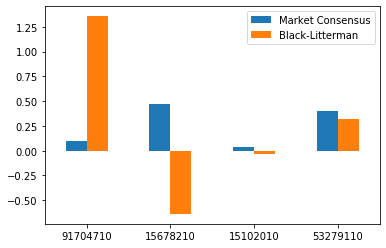

In [12]:
# Import pyplot from the matplotlib library
import matplotlib.pyplot as plt
# Create a  dataframe of the stock weights based on market consensus and Black-Litterman
analysis_tbl = pd.DataFrame({'Market Consensus':[w_mkt[0,0], w_mkt[0,1], w_mkt[0,2], w_mkt[0,3]],
                             'Black-Litterman':[bl_w[0,0], bl_w[1,0], bl_w[2,0], bl_w[3,0]]},
                            index=smp_out_names)
# Plot the dataframe
analysis_plt = analysis_tbl.plot.bar(rot=0)

Based on the market capitalization, it appears the preferred stocks to invest in are CUSIPs 15678210 and 53279110. However, since the views used to generate the Black-Litterman allocation believed that 91704710 would outperform all the other stocks selected and that 15678210 would perform the worst, the allocations were adjusted accordingly.

# Works Cited

Becker, Thomas. “The Black-Litterman Model: An Introduction for the Practitioner.” The Investment Management Consultants Association's Investments & Wealth Monitor, vol. 6, 2009, pp. 21–24., doi: [https://www.styleadvisor.com/content/black-litterman-model](https://www.styleadvisor.com/content/black-litterman-model)

Pei, Kevin. “Sector Weighting: A Detailed Implementation of Black-Litterman.” Sector Weighting: A Detailed Implementation of Black-Litterman, The Sprott Student Investment Fund of Carleton University, 6 May 2015, [kpei.github.io/bl-sector-ssif/bl.html](kpei.github.io/bl-sector-ssif/bl.html)

Seimertz, Daniel. Black-Litterman Allocation Model: Application and Comparision with OMX Stockholm Benchmark PI (OMXSBPI). Lund University Publications, 2015, Black-Litterman Allocation Model: Application and Comparision with OMX Stockholm Benchmark PI (OMXSBPI), [lup.lub.lu.se/luur/download?func=downloadFile&recordOId=5472145&fileOId=5472158](lup.lub.lu.se/luur/download?func=downloadFile&recordOId=5472145&fileOId=5472158)